# Potato Leaf Disease Classification
In this project, we use a Convolutional Neural Network (CNN) to classify potato leaf diseases into three categories Healthy, Early Blight and Late Blight.
The dataset used in this project is from Kaggle, PlantVillage Dataset is a popular dataset for plant disease classification. It contains images of potato leaves affected by various diseases.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers,models

In [3]:
# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(256, 256),
    batch_size=32
)

class_names = dataset.class_names
print("Class Names:", class_names)

Found 2152 files belonging to 3 classes.
Class Names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [4]:
# Split the dataset into training, testing and validation sets
train_size = int(0.7 * len(dataset))  # 70% for training
val_size = int(0.15 * len(dataset))  # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining for testing

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size + val_size)

print("Train size:", len(train_ds))
print("Validation size:", len(val_ds))
print("Test size:", len(test_ds))

Train size: 47
Validation size: 10
Test size: 11


In [5]:
# Data augmentation for training
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# Resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1.0 / 255)
])

In [6]:
# Apply transformations
train_ds = train_ds.map(lambda x, y: (data_augmentation(resize_and_rescale(x)), y)) \
                   .cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y)) \
               .cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y)) \
                 .cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(len(class_names), activation="softmax")  # Number of classes
])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 868,099 (3.31 MB)

 Trainable params: 868,099 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Compile the model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [14]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25
)

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 52s 702ms/step - accuracy: 0.4957 - loss: 0.9659 - val_accuracy: 0.7937 - val_loss: 0.7650
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 714ms/step - accuracy: 0.7780 - loss: 0.6771 - val_accuracy: 0.8094 - val_loss: 0.4780
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 689ms/step - accuracy: 0.8432 - loss: 0.4492 - val_accuracy: 0.8750 - val_loss: 0.3590
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 686ms/step - accuracy: 0.8577 - loss: 0.3588 - val_accuracy: 0.8781 - val_loss: 0.3355
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 738ms/step - accuracy: 0.8894 - loss: 0.2748 - val_accuracy: 0.9438 - val_loss: 0.1594
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 740ms/step - accuracy: 0.9009 - loss: 0.2472 - val_accuracy: 0.9438 - val_loss: 0.1332
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 702ms/step - accuracy: 0.9573 - loss: 0.1413 - val_accuracy: 0.9469 - val_loss: 0.1577
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 745ms/step - accuracy: 0.9509 - loss: 0.1275 - val_accu

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9583 - loss: 0.1829
Test Accuracy: 95.43%
Test Loss: 19.27%


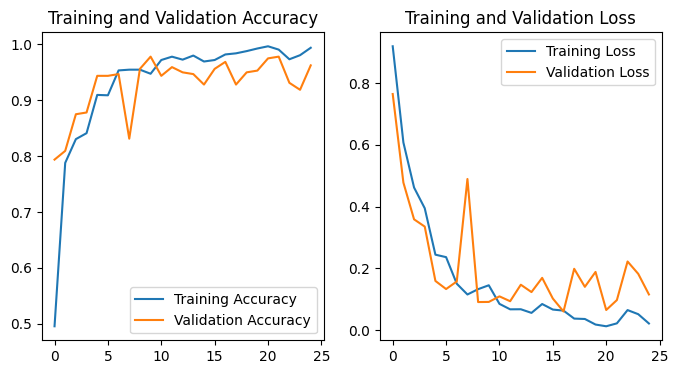

In [15]:
# Evaluate on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss * 100:.2f}%")

# Plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [18]:
# Save the model
model.save("./model/potato.keras")